In [1]:
from pathlib import Path
import os

from dataclasses import dataclass
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

import random
from tqdm.auto import tqdm
from PIL import Image
from IPython.display import HTML
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

import torch
import torch.nn.functional as F

from diffusers import UNet2DConditionModel, DDPMScheduler, DDPMPipeline, DDIMScheduler
from diffusers import AutoencoderKL
from diffusers.optimization import get_cosine_schedule_with_warmup
from transformers import CLIPTextModel, CLIPTokenizer, logging
from accelerate import Accelerator
from torchvision import transforms

2025-05-22 13:08:15.905588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747919296.091808      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747919296.146886      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[1] Training Parameters

In [3]:
@dataclass
class TrainConfig:
    image_size = 256
    latent_size = 16

    train_batch_size = 96
    eval_batch_size = 16
    eval_steps = 50

    num_epochs = 10
    save_image_epochs = 1
    save_model_epochs = 1
    start_from_checkpoint = True

    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 0

    uncond_prob = 0.15          #For Classifier-Free Guidance Training

    mixed_precision = "fp16"
    output_dir = ""
    seed = 32

config = TrainConfig()
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### [1] Prepare Dataset

We will precompute the latents from the dataset and tokenize the captions.  
If you prefer to skip this step, you can simply download the precomputed data from the link provided in `precompute/README.md` and jump directly to **Section [2] Training**.

To manually precompute latents and tokenize captions, follow these steps:

1. Download the **"images (HQ)"** (approximately 2.9 GB) and **"captions_hq.json"** (approximately 18 MB) from the [CelebA-Dialogue](https://github.com/ziqihuangg/CelebA-Dialog) repository.

2. Extract the images and note the path to the image folder  
   (e.g., `/kaggle/input/celeba-with-captions/image/image/`).

3. Similarly, locate the path to `captions_hq.json`  
   (e.g., `/kaggle/input/celeba-with-captions/captions_hq.json`).

In [10]:
import json

class ImageFolderDataset(Dataset):
    def __init__(self, img_folder, cc_json, transform=None):
        self.image_paths = [os.path.join(img_folder, fname) 
                            for fname in os.listdir(img_folder)
                            if fname.lower().endswith(('.jpg'))]
        self.image_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        self.transform = transform

        #Somehow 5380.json has no label so we need to create one, we can just make it empty
        with open(cc_json, 'r') as f:
            self.cc = json.load(f)
        self.cc["5380.jpg"] = {
            "overall_caption": ""
        }

        # Sort keys numerically to align with image_paths
        sorted_keys = sorted(self.cc.keys(), key=lambda x: int(os.path.splitext(x)[0]))
        # Extract captions in sorted order
        self.cc = [self.cc[k]["overall_caption"] for k in sorted_keys]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        prompt = self.cc[idx]
        return {
            'image':image,
            'prompt':prompt,
        }

transform = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

dataset = ImageFolderDataset("/kaggle/input/celeba-with-captions/image/image/", "/kaggle/input/celeba-with-captions/captions_hq.json", transform=transform)

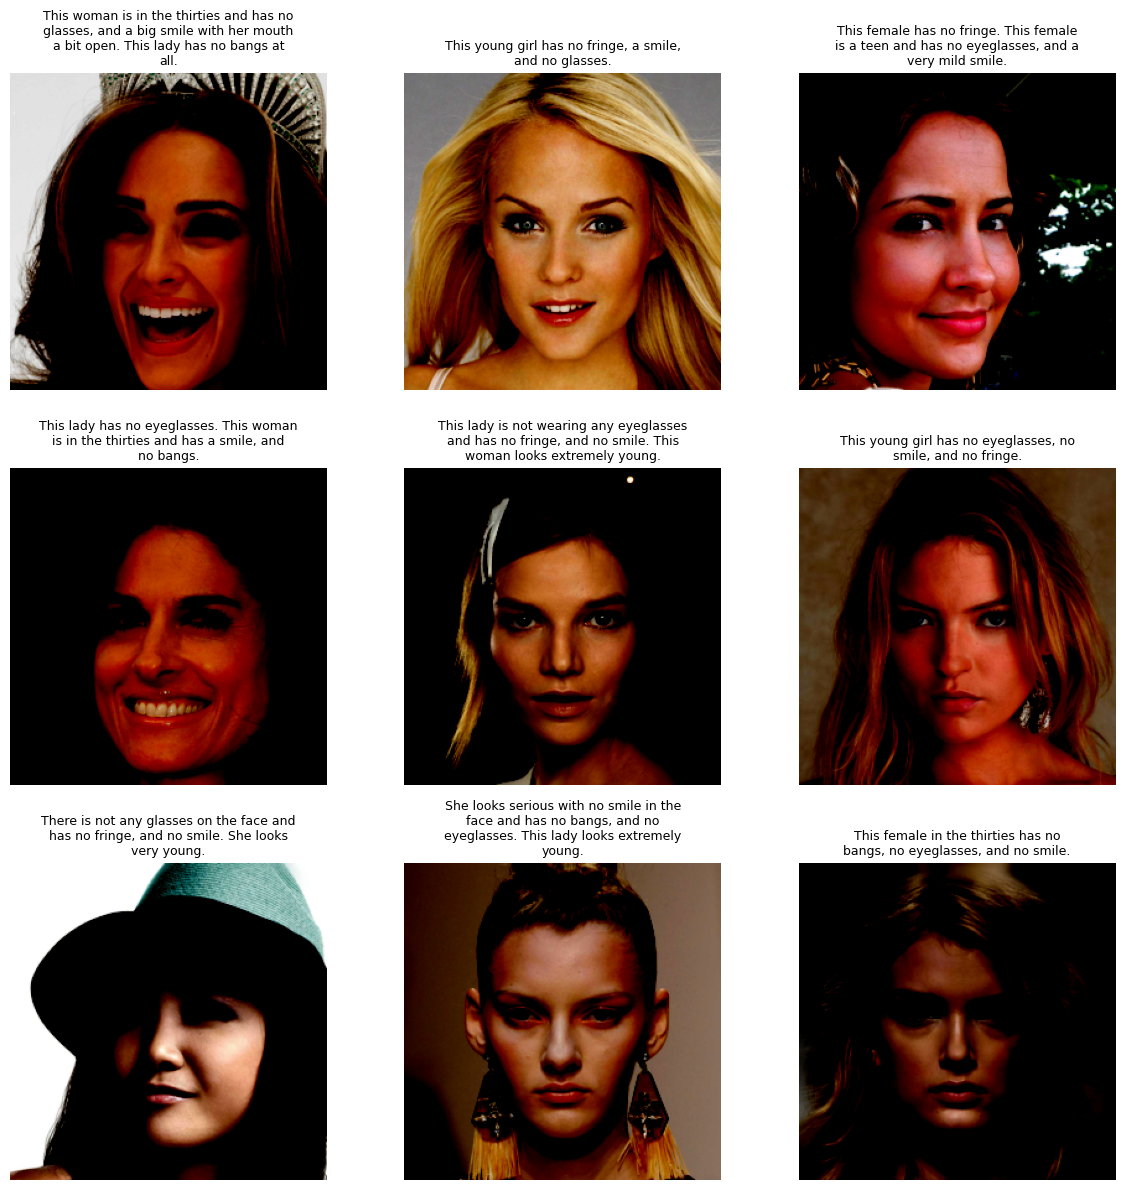

In [34]:
import textwrap

# Settings
rows, cols = 3, 3
num_images = rows * cols

fig, axs = plt.subplots(rows, cols, figsize=(12, 12))  # Adjust size for better layout

for i in range(num_images):
    image = dataset[i]['image'].permute(1, 2, 0)
    caption = dataset[i]['prompt']
    
    # Wrap the caption to fit under the image
    wrapped_caption = "\n".join(textwrap.wrap(caption, width=40))  # 40 characters per line
    
    ax = axs[i // cols, i % cols]
    ax.imshow(image)
    ax.set_axis_off()
    ax.set_title(wrapped_caption, fontsize=9)

plt.tight_layout()
fig.savefig('thumbnail.png')
plt.show()

In [5]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

vae = vae.to(torch_device)
text_encoder.to(torch_device)

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

Precompute latents

In [ ]:
def img_to_latent(input_im):
    #Image tensor (B, 3, 256, 256) -> Latent (B, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(input_im.to(torch_device)*2 - 1)
    
    # 0.18215 is just to make sure dataset has var close to 1, while decoding we need to scale latent back with (1/0.18215)
    return 0.18215 * latent.latent_dist.sample()

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

all_latents = []
for idx, batch in enumerate(dataloader):
    lat = img_to_latent(batch["image"])
    # move back to CPU and store
    all_latents.append(lat)
    if idx % 16 == 0:
        print(f"Processed {idx * dataloader.batch_size} images")

In [ ]:
all_latents_cpu = [l.cpu() for l in all_latents]
all_latents_cpu = torch.cat(all_latents_cpu, dim=0)
torch.save(all_latents_cpu, "all_latents_tensor.pt")

Tokenize prompts

In [45]:
all_prompts_tokenized = []
tokenize_batch = 1024
i = 0

dataloader = DataLoader(
    dataset,
    batch_size=tokenize_batch,
    shuffle=False,
    num_workers=2,
)

for idx, batch in enumerate(dataloader):
   temp = tokenizer(batch['prompt'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
   all_prompts_tokenized.append(temp.input_ids)
   if i % 5*1024 == 0:
      print(i)
   i += tokenize_batch

0
5120
10240
15360
20480
25600


In [48]:
all_prompts_tokenized = torch.cat(all_prompts_tokenized, dim=0)
torch.save(all_prompts_tokenized, 'all_prompts_tokenized.pt')

### [2] Training LDM

At this point, it's a good idea to restart the notebook to clear any GPU memory.

- **Do not load the VAE**, as it is not required for training.
- **The text model is required**, since it will embed the tokenized prompts during training.

Now, let's load the precomputed data.

In [ ]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# vae = vae.to(torch_device)
text_encoder.to(torch_device)

In [6]:
all_latents_tensor = torch.load("all_latents_tensor.pt", map_location="cpu")
all_prompts_tokenized = torch.load("all_prompts_tokenized.pt", map_location="cpu")

In [ ]:
#Getting largest multiple of dataset size
all_latents_tensor = all_latents_tensor[:(30_000//config.train_batch_size)*config.train_batch_size]
all_prompts_tokenized = all_prompts_tokenized[:(30_000//config.train_batch_size)*config.train_batch_size]

Creating and Training LDM

In [ ]:
class TextLatentDataset(Dataset):
    def __init__(self, latents, prompts):
        self.latents = latents  # [N, C, H, W]
        self.prompts = prompts  # [N, 77]

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        latent = self.latents[idx]
        prompt = self.prompts[idx]
        return {
            "latent": latent,
            "prompt_ids": prompt,
        }

dataset = TextLatentDataset(all_latents_tensor, all_prompts_tokenized)
dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=2, prefetch_factor=2)

In [10]:
unet = UNet2DConditionModel(
    sample_size=32,             # 32x32 resolution
    in_channels=4,              # latent channels
    out_channels=4,             # predict noise (or v)
    cross_attention_dim=768,    # text embedding dimension (CLIP/BERT)
    attention_head_dim=8,
    block_out_channels=[128, 256, 512],
    layers_per_block=2,
    down_block_types=(
        "CrossAttnDownBlock2D",   # 32 -> 16
        "CrossAttnDownBlock2D",   # 16 -> 8
        "CrossAttnDownBlock2D",   # 8 -> 4
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",     # 4 -> 8
        "CrossAttnUpBlock2D",     # 8 -> 16
        "CrossAttnUpBlock2D",     # 16 -> 32
    )
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, prediction_type="epsilon")

In [12]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

In [ ]:
eval_fixed_prompt = all_prompts_tokenized[:config.eval_batch_size]
eval_fixed_prompt = eval_fixed_prompt.to(torch_device)
with torch.no_grad():
    eval_fixed_embedd = text_encoder(eval_fixed_prompt)["last_hidden_state"]

latents = all_latents_tensor[:config.eval_batch_size]

def evaluate(config, epoch, inf_timesteps, model, scheduler_typ, eta = 1, eval_fixed_embedd=eval_fixed_embedd):
    #Simply sample some latents and average the channels and save them for inspection
    if scheduler_typ=="ddpm":
        scheduler = DDPMScheduler(num_train_timesteps=1000)
    elif scheduler_typ=="ddim":
        scheduler = DDIMScheduler(num_train_timesteps=1000)

    scheduler.set_timesteps(inf_timesteps)
    scheduler.timesteps = scheduler.timesteps.to(torch_device)
    
    B, C, H, W = config.eval_batch_size, 4, 32, 32
    latents = torch.randn((B, C, H, W), device=torch_device)

    for t in tqdm(scheduler.timesteps):
        with torch.no_grad():
            noise_pred = model(latents, t, encoder_hidden_states=eval_fixed_embedd).sample
        
        if scheduler_typ == "ddim":
            latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
        elif scheduler_typ == "ddpm":
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    avg_latents = latents.mean(dim=1)

    grid = make_grid(avg_latents.unsqueeze(1), nrow=4, padding=2)  # (1, H, W) per image

    path = Path(f"./{config.output_dir}/samples")
    path.mkdir(parents=True, exist_ok=True)

    img1 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
    img1.save(f"./{config.output_dir}/samples/eval_latents_{epoch}.png")

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    uncond_input = tokenizer([""]*config.train_batch_size, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt").input_ids
    uncond_input = uncond_input.to(torch_device)

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Training Loop
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            latents = batch["latent"]
            prompts = batch["prompt_ids"]

            if torch.rand(1).item() < config.uncond_prob: ### To Enable Classifier Free Guidance
                prompts = uncond_input

            with torch.no_grad():
                text_embeddings = text_encoder(prompts)["last_hidden_state"]

            # Sample noise to add to the images
            noise = torch.randn_like(latents).to(torch_device)
            bs = latents.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=torch_device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            with accelerator.accumulate(model):
                noise_pred = model(noisy_latents, timesteps, encoder_hidden_states=text_embeddings, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, config.eval_steps, model, "ddim", eta = 1)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(os.path.join(config.output_dir, f"checkpoint_{epoch}"))

In [13]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

In [ ]:
from accelerate import notebook_launcher

args = (config, unet, noise_scheduler, optimizer, dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

### [3] Inference Time

It's recommended to restart the notebook again to clear GPU memory.

At this stage, make sure to **load the VAE**, as it is required to run the full inference loop.

In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

vae = vae.to(torch_device)
text_encoder.to(torch_device)

In [ ]:
#Load the best model checkpoint
unet = UNet2DConditionModel.from_pretrained(os.path.join("cc_2", f"checkpoint_9", "unet"))
noise_scheduler = DDPMScheduler.from_pretrained(os.path.join("cc_2", f"checkpoint_9", "scheduler"))

unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 128, eps=1e-06, affine=True)
          (proj_in): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=128, out_features=128, bias=False)
                (to_k): Linear(in_features=128, out_features=128, bias=False)
                (to_v): Linear(in_features=128, out_featu

Let's see output without guidance

In [ ]:
eval_fixed_prompt = all_prompts_tokenized[:config.eval_batch_size]
eval_fixed_prompt = eval_fixed_prompt.to(torch_device)

with torch.no_grad():
    eval_fixed_embedd = text_encoder(eval_fixed_prompt)["last_hidden_state"]

latents = all_latents_tensor[:config.eval_batch_size]

def latents_to_pil(latents):
    #Latent(B, 4, 64, 64) -> Image (3, 512, 512)
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def evaluate(config, epoch, inf_timesteps, model, scheduler_typ, eta = 1, eval_fixed_embedd=eval_fixed_embedd):
    if scheduler_typ=="ddpm":
        scheduler = DDPMScheduler(num_train_timesteps=1000)
    elif scheduler_typ=="ddim":
        scheduler = DDIMScheduler(num_train_timesteps=1000)

    scheduler.set_timesteps(inf_timesteps)
    scheduler.timesteps = scheduler.timesteps.to(torch_device)
    
    B, C, H, W = config.eval_batch_size, 4, 32, 32
    latents = torch.randn((B, C, H, W), device=torch_device)

    for t in tqdm(scheduler.timesteps):
        with torch.no_grad():
            noise_pred = model(latents, t, encoder_hidden_states=eval_fixed_embedd).sample
        
        if scheduler_typ == "ddim":
            latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
        elif scheduler_typ == "ddpm":
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    avg_latents = latents.mean(dim=1)

    grid = make_grid(avg_latents.unsqueeze(1), nrow=4, padding=2)  # (1, H, W) per image

    path = Path(f"./{config.output_dir}/samples")
    path.mkdir(parents=True, exist_ok=True)

    img1 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
    img1.save(f"./{config.output_dir}/samples/eval_latents_{epoch}.png")

    latents = (1 / 0.18215) * latents

    with torch.no_grad():
        image = vae.decode(latents).sample
    
    grid = make_grid(image, nrow=4, padding=2)

    img2 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
    img2.save(f"./{config.output_dir}/samples/eval_decoded_{epoch}.png")

    return img1, img2

  0%|          | 0/50 [00:00<?, ?it/s]

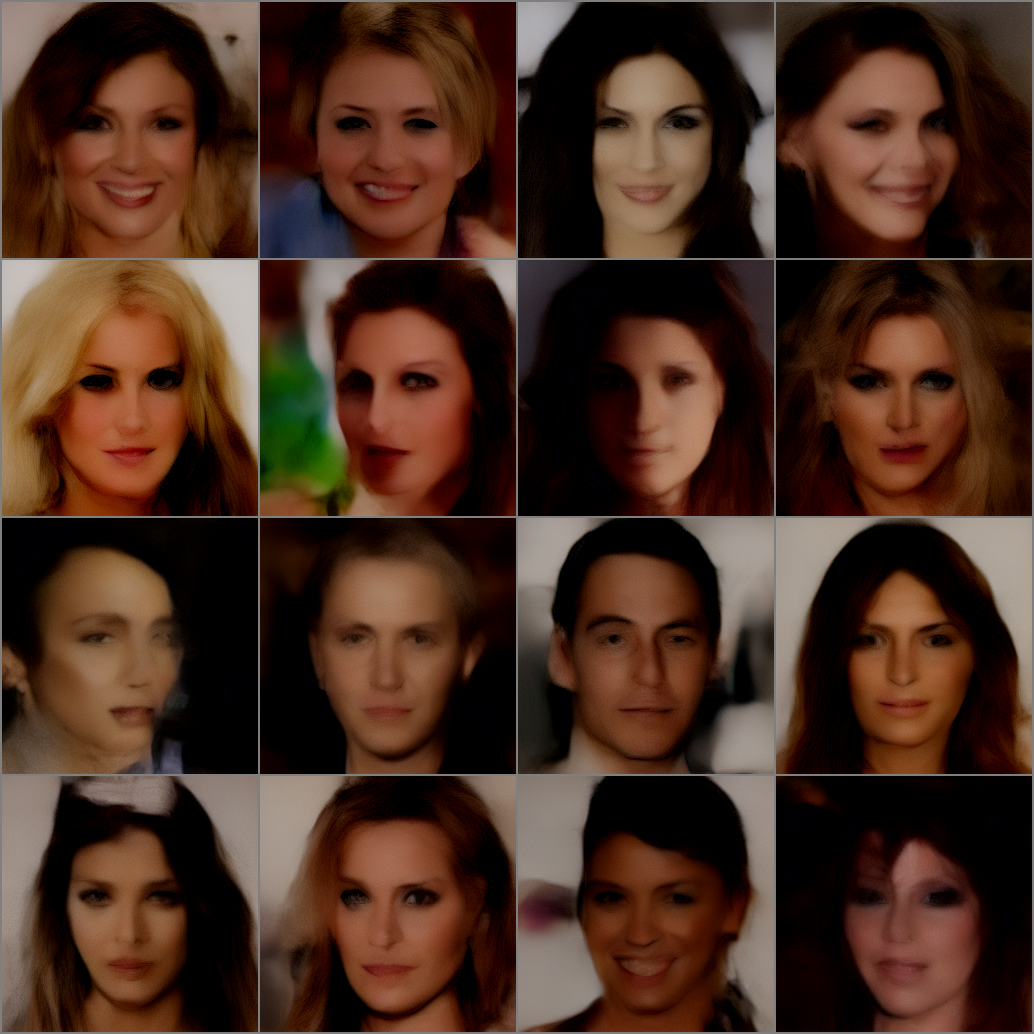

In [7]:
img1, img2 = evaluate(config, 69, 50, unet, "ddim", eta = 1, eval_fixed_embedd=eval_fixed_embedd)
img2

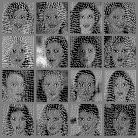

In [9]:
img1

In [32]:
from torchvision import transforms as tfms

def pil_to_latents(input_im):
    #Image (B, 3, 512, 512) -> Latent(B, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(input_im.to(torch_device)*2 -1)
    return 0.18215 * latent.latent_dist.sample()

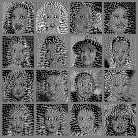

In [ ]:
# dataset[0]['image']
imgs = torch.cat([dataset[i]['image'].unsqueeze(0) for i in range(16)], dim=0)

latents = pil_to_latents(imgs)

avg_latents = latents.mean(dim=1)

grid = make_grid(avg_latents.unsqueeze(1), nrow=4, padding=2)  # (1, H, W) per image

img1 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
img1

Let's see what prompts model is trained on

In [ ]:
for i, p in enumerate(all_prompts_tokenized[100:200]):
    decoded = tokenizer.decode(p, skip_special_tokens=True)
    print(f"[{i}] {decoded}")

[0] this guy doesn 't have any beard at all . this man is in his thirties and has no smile , and no glasses . the whole forehead is visible without any fringe .
[1] there is not any eyeglasses on the face and has no fringe , and no smile . she is a young adult .
[2] this person has no bangs , no smile , and no eyeglasses . this woman is a young adult .
[3] this female is not wearing any eyeglasses and has no smile , and no fringe . this lady is a young adult .
[4] this lady in the thirties has long bangs that almost covers this full forehead , no glasses , and a smile with the teeth visible .
[5] this female has no bangs , and no glasses . she is in the thirties and has a smile with her teeth visible .
[6] she is not wearing any glasses and has no bangs , and a mild smile . this woman is a young adult .
[7] this lady has no fringe at all . this lady is a teenager and has no smile , and no eyeglasses .
[8] this young person has no glasses , and no bangs . this lady has a beaming face .


Implementing Guidance

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_75/509009384.py:52: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


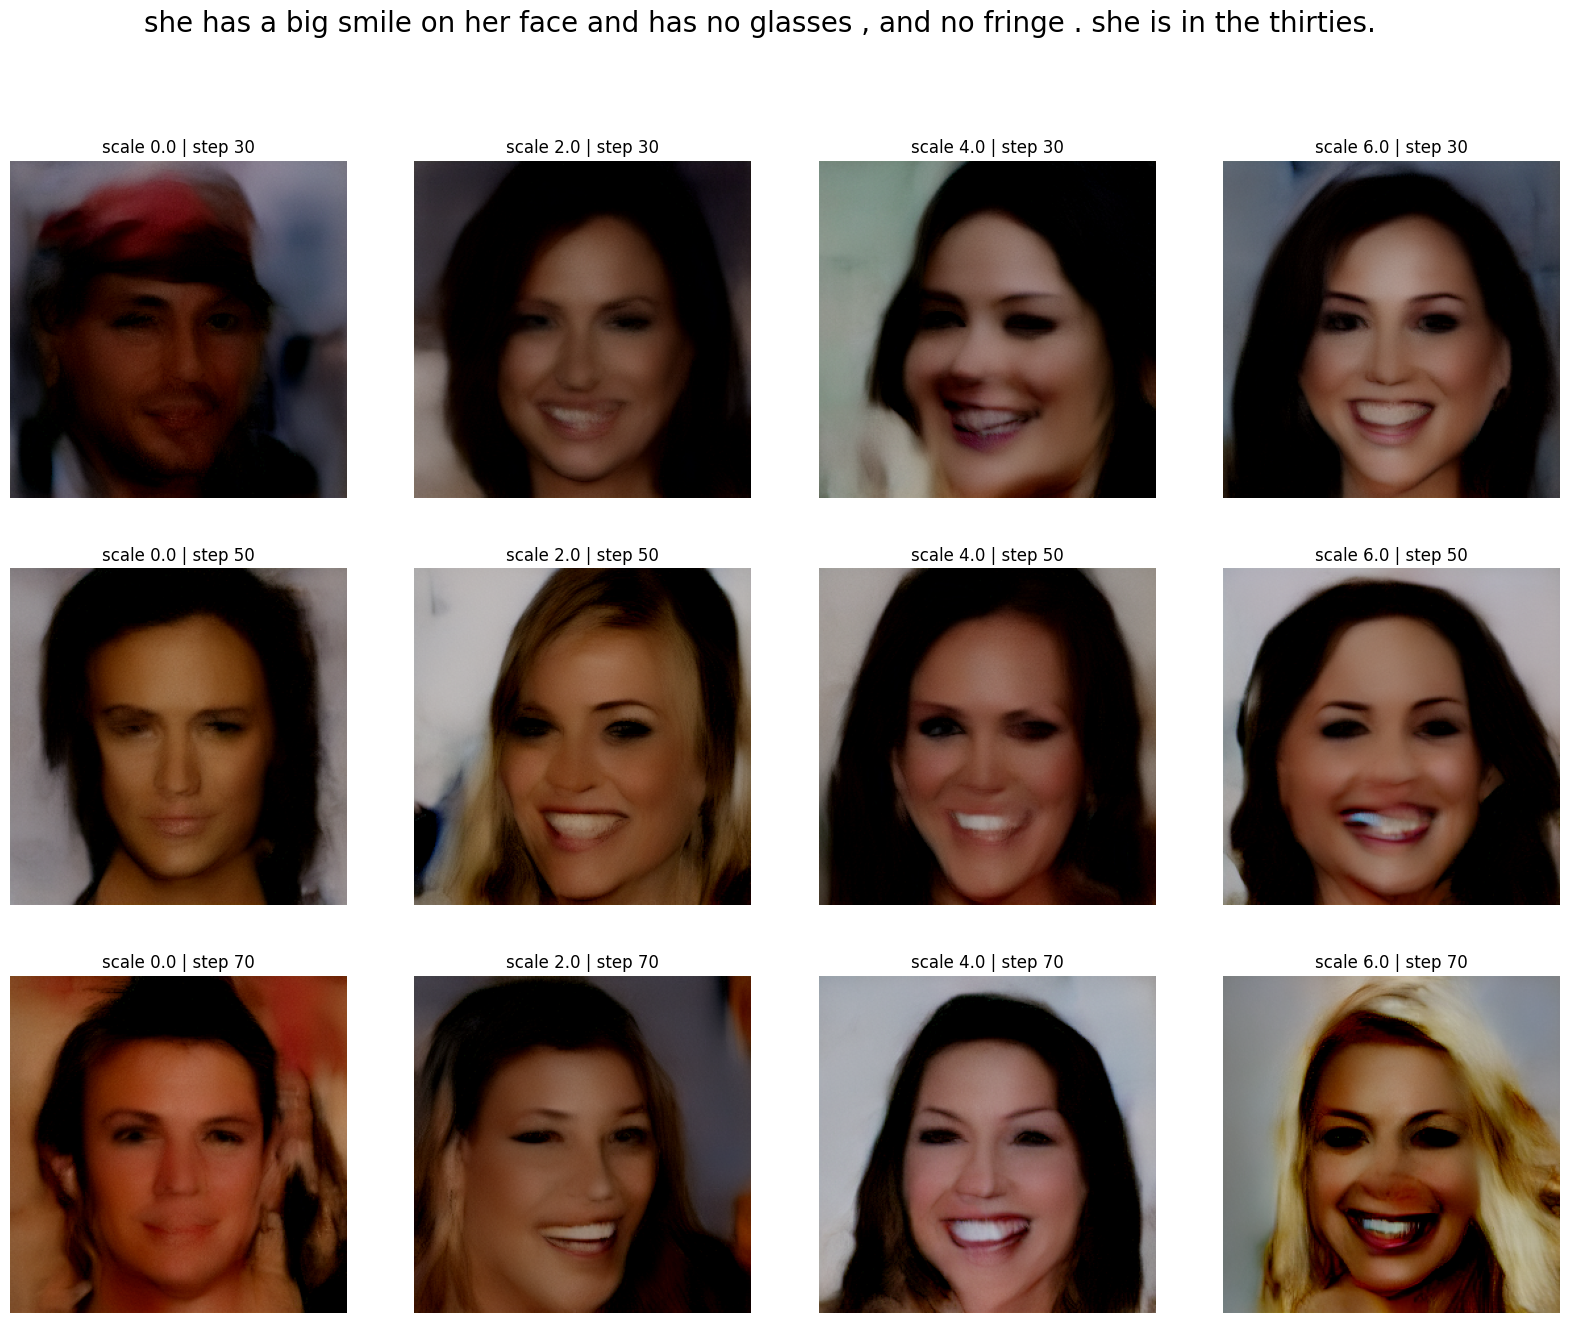

In [ ]:
import torchvision.transforms as T

def pil_to_latents(input_im):
    #Image (3, 512, 512) -> Latent(1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2 -1)
    return 0.18215 * latent.latent_dist.sample()

def text_to_img_grid(config, unet, prompt, inference_step_list, guidance_list, scheduler_class, eta=1.0, custom=None):
    height = config.image_size
    width = config.image_size
    generator = torch.Generator(device=torch_device).manual_seed(31)
    batch_size = 1  # assuming single prompt        

    # Tokenize input
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    # Unconditioned text
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    fig, axs = plt.subplots(len(inference_step_list), len(guidance_list), figsize=(5*len(guidance_list) ,5*len(inference_step_list)))
    fig.suptitle(prompt[0], fontsize=20)

    if scheduler_class=="ddpm":
        scheduler = DDPMScheduler(num_train_timesteps=1000)
    elif scheduler_class=="ddim":
        scheduler = DDIMScheduler(num_train_timesteps=1000)

    if custom is not None:
        print("custom")

    for j, guidance_scale in tqdm(enumerate(guidance_list), total=len(guidance_list)):
        for i, num_inference_steps in enumerate(inference_step_list):
        
            scheduler.set_timesteps(num_inference_steps)

            if custom is not None:
                latents = pil_to_latents(Image.open(custom))
                latents = latents.expand(batch_size, -1, -1, -1).clone()
                noise = torch.randn(
                    (batch_size, unet.in_channels, height // 8, width // 8),
                    device=torch_device,
                )
                latents = scheduler.add_noise(latents, noise, torch.tensor([100], device=torch_device))
            else:
                latents = torch.randn(
                    (batch_size, unet.in_channels, height // 8, width // 8),
                    generator=generator,
                    device=torch_device,
                )

            # Expand the embeddings to shape (2, batch, dim)
            cond_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)

            for t in scheduler.timesteps:
                latent_input = torch.cat([latents] * 2)
                with torch.no_grad():
                    noise_pred = unet(latent_input, t, encoder_hidden_states=cond_embeddings).sample

                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                if scheduler_class == "ddim":
                    latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
                elif scheduler_class == "ddpm":
                    latents = scheduler.step(noise_pred, t, latents).prev_sample

            latents = (1 / 0.18215) * latents
            with torch.no_grad():
                image = vae.decode(latents).sample

            image = (image / 2 + 0.5).clamp(0, 1)
            axs[i, j].imshow(image.cpu()[0].permute(1,2,0).numpy())
            axs[i, j].set_axis_off()
            axs[i, j].set_title(f"scale {guidance_list[j]} | step {inference_step_list[i]}")
    fig.savefig(f"{prompt[0]}.png")
    fig.show()

# Example usage:
grid_img = text_to_img_grid(
    config=config,
    unet=unet,
    prompt=["she has a big smile on her face and has no glasses , and no fringe . she is in the thirties."],
    inference_step_list=[30, 50, 70],
    guidance_list=[0.0, 2.0, 4.0, 6.0],
    scheduler_class="ddim",
    eta=0.8,
    custom = None
)